In [1]:
from data import *
from classifiers import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
%matplotlib inline

In [2]:
metadata_train, experiments_train = load_data(os.path.join("..", "data", "train"), "")
truth_train, metadata_train = categorize_metadata(metadata_train)
metadata_test, experiments_test = load_data(os.path.join("..", "data", "test"), "")
truth_test, metadata_test = categorize_metadata(metadata_test)

# Look for optimal classifier parameters for arbitrary processing parameters

In [3]:
process_params = {
    'baseline_lam': 10,
    'baseline_p': 1e-2,
    'smooth_window_length': 7,
    'smooth_polyorder': 3
}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)

In [4]:
param_grid = {
    'n_estimators': range(1, 501, 100),
    'max_depth': range(1, 21, 5)
}

clf = RandomForestClassifier()

grid_clf = GridSearchCV(clf, param_grid, cv=5)
_ = grid_clf.fit(X_train, truth_train.to_numpy().ravel())

In [5]:
print(grid_clf.best_params_)
grid_clf.cv_results_

{'max_depth': 11, 'n_estimators': 301}


{'mean_fit_time': array([0.00681539, 0.14610763, 0.27718945, 0.39620948, 0.52502027,
        0.00736065, 0.43403726, 0.86569772, 1.2813745 , 1.70391393,
        0.00718741, 0.48835073, 0.9537066 , 1.4265492 , 1.93588476,
        0.00835772, 0.48221674, 0.94742947, 1.42890635, 1.93304458]),
 'std_fit_time': array([0.00046738, 0.00867747, 0.01135155, 0.00112488, 0.00349504,
        0.00088113, 0.00534944, 0.00746005, 0.00887032, 0.01338315,
        0.00048124, 0.00671597, 0.01533272, 0.01902896, 0.03648975,
        0.00067703, 0.00985057, 0.01882552, 0.0128699 , 0.01072727]),
 'mean_score_time': array([0.00065007, 0.00185828, 0.00349832, 0.00409431, 0.00529351,
        0.00024419, 0.00252962, 0.00395293, 0.00567269, 0.00726399,
        0.0006793 , 0.00220752, 0.0038765 , 0.00551586, 0.00653486,
        0.00045471, 0.00235896, 0.00373554, 0.00502024, 0.00725088]),
 'std_score_time': array([0.00053118, 0.00048533, 0.00020484, 0.00057571, 0.00022786,
        0.00048838, 0.00076014, 0.000493

In [6]:
evaluate_classifier_params(RandomForestClassifier, grid_clf.best_params_, X_train, truth_train, X_test, truth_test, iters=20)

(1.0, 0.9426553672316386)

# Look for optimal processing and classifier parameters

In [7]:
param_grid = {
    'baseline_lam': range(1,21,5),
    'baseline_p': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'smooth_window_length': [3,5,9,15,21],
    'smooth_polyorder': [3,5,9,15,21],
    'n_estimators': [100], #range(1, 101, 100),
    'max_depth': [10] #range(5, 16, 5)
}
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    results = param_grid_search(RandomForestClassifier, param_grid, experiments_train, metadata_train, truth_train, cv=5)

[{'baseline_lam': 1, 'baseline_p': 0.1, 'max_depth': 10, 'n_estimators': 100, 'smooth_polyorder': 3, 'smooth_window_length': 5}, {'fit_time': array([0.5342443 , 0.5351305 , 0.51417208, 0.53326702, 0.52174711]), 'score_time': array([0.00225377, 0.00225544, 0.00217366, 0.0022366 , 0.00257421]), 'estimator': [RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=10)], 'test_score': array([0.8490566 , 0.83018868, 0.83018868, 0.91428571, 0.86666667])}]
[{'baseline_lam': 1, 'baseline_p': 0.1, 'max_depth': 10, 'n_estimators': 100, 'smooth_polyorder': 3, 'smooth_window_length': 9}, {'fit_time': array([0.52323151, 0.51764464, 0.52236128, 0.52475786, 0.52849317]), 'score_time': array([0.00286651, 0.00227451, 0.00227356, 0.00338054, 0.00214696]), 'estimator': [RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=10), RandomForestClassifier(max_depth=

In [8]:
k = 0
best_params = dict()
for r in results:
    mean = np.mean(r[1]['test_score'])
    if mean > k:
        k = mean
        best_params = r[0]
k, best_params

(0.9697574123989219,
 {'baseline_lam': 11,
  'baseline_p': 0.001,
  'max_depth': 10,
  'n_estimators': 100,
  'smooth_polyorder': 5,
  'smooth_window_length': 21})

In [9]:
process_params = {key: best_params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
classifier_params = {key: best_params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=20)

(1.0, 0.977966101694915)

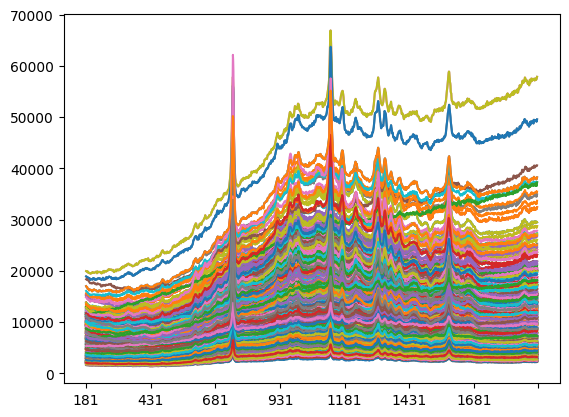

In [10]:
clf = RandomForestClassifier(**classifier_params)
clf.fit(X_train, truth_train.to_numpy().ravel())
_ = experiments_train.transpose().plot(legend=False)

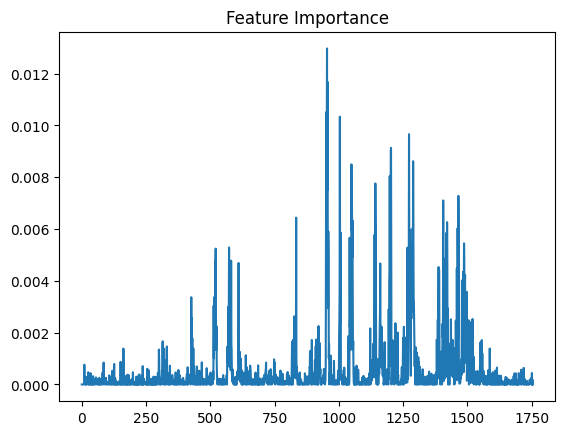

In [11]:
_ = plt.plot(clf.feature_importances_)
_ = plt.title("Feature Importance")

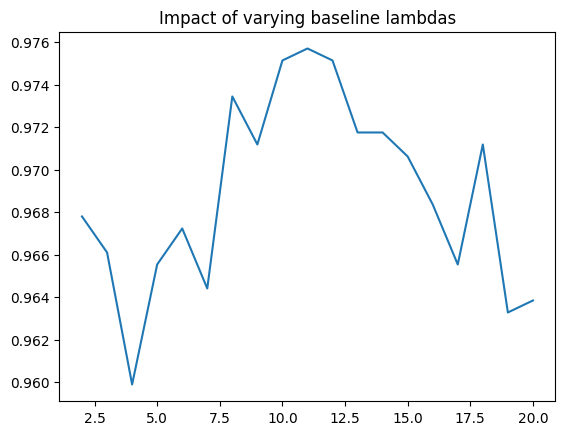

In [13]:
to_plot = []
params = best_params.copy()
for baseline_lam in range(2, 21):
    params['baseline_lam'] = baseline_lam
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10)[1])
_ = plt.plot(range(2, 21), to_plot)
_ = plt.title("Impact of varying baseline lambdas")

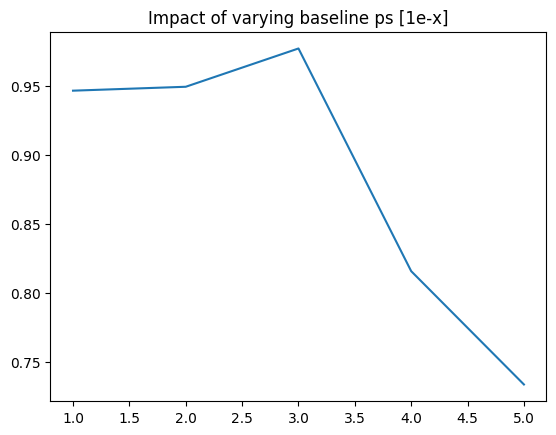

In [14]:
to_plot = []
params = best_params.copy()
for baseline_p in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    params['baseline_p'] = baseline_p
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10)[1])
_ = plt.plot([1, 2, 3, 4, 5], to_plot)
_ = plt.title("Impact of varying baseline ps [1e-x]")

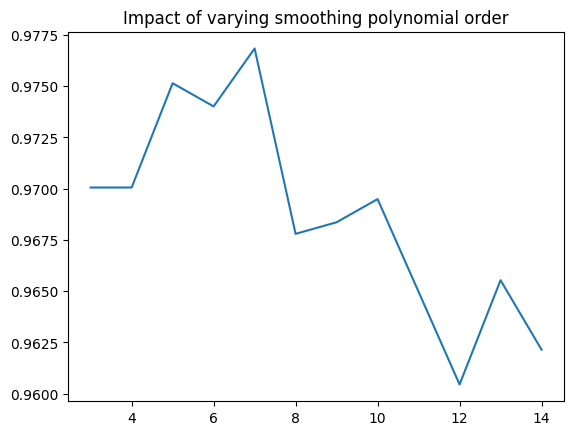

In [15]:
to_plot = []
params = best_params.copy()
for smooth_polyorder in range(3, 15):
    params['smooth_polyorder'] = smooth_polyorder
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10)[1])
_ = plt.plot(range(3, 15), to_plot)
_ = plt.title("Impact of varying smoothing polynomial order")

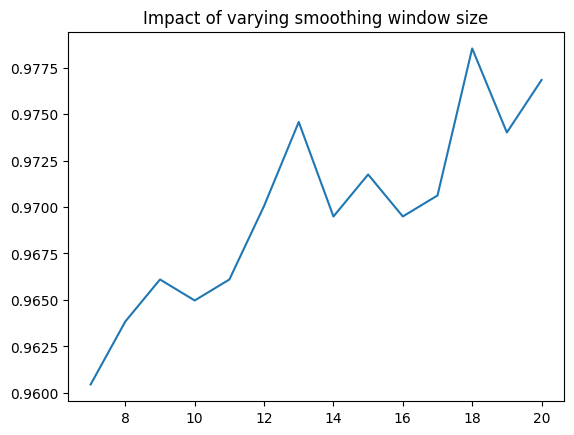

In [16]:
to_plot = []
params = best_params.copy()
for smooth_window_length in range(7, 21):
    params['smooth_window_length'] = smooth_window_length
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10)[1])
_ = plt.plot(range(7, 21), to_plot)
_ = plt.title("Impact of varying smoothing window size")

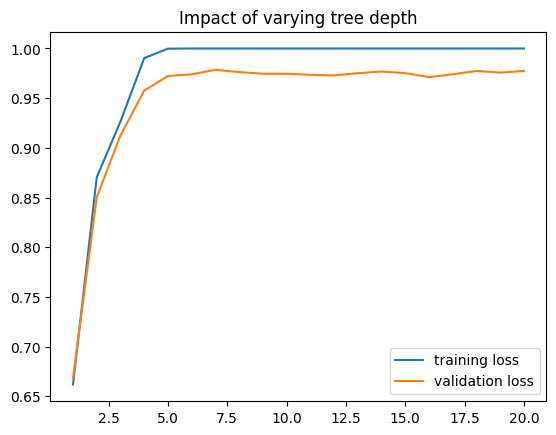

In [17]:
to_plot = []
params = best_params.copy()
for max_depth in range(1, 21):
    params['max_depth'] = max_depth
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10))
_ = plt.plot(range(1, 21), to_plot)
_ = plt.title("Impact of varying tree depth")
_ = plt.legend(["training loss", "validation loss"])

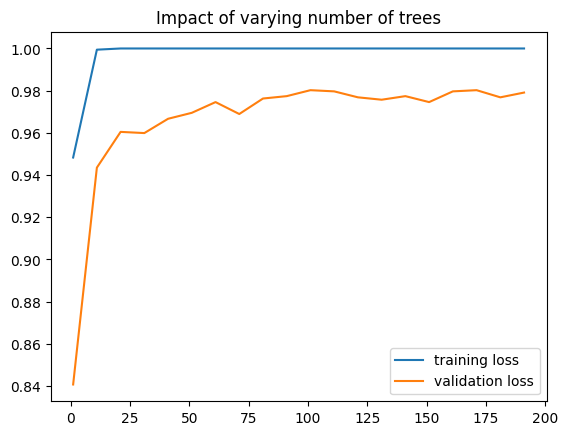

In [18]:
to_plot = []
params = best_params.copy()
for n_estimators in range(1, 201, 10):
    params['n_estimators'] = n_estimators
    process_params = {key: params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    classifier_params = {key: params[key] for key in best_params.keys() if key not in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
    X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=True)
    to_plot.append(evaluate_classifier_params(RandomForestClassifier, classifier_params, X_train, truth_train, X_test, truth_test, iters=10))
_ = plt.plot(range(1, 201, 10), to_plot)
_ = plt.title("Impact of varying number of trees")
_ = plt.legend(["training loss", "validation loss"])

# Removing data

In [19]:
process_params = {key: best_params[key] for key in ['baseline_lam', 'baseline_p', 'smooth_window_length', 'smooth_polyorder']}
X_train, X_test = process_train_test(process_params, experiments_train, metadata_train, experiments_test, metadata_test, scale=False)

In [21]:
param_grid = {
    'n_estimators': range(1, 201, 100),
    'max_depth': range(5, 21, 5)
}
results = []
X_size = []
for min_std in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]:
    to_drop = X_train.std() > min_std
    X_train_small = X_train.loc[:, to_drop]
    X_size.append(len(X_train_small.columns))

    scaler = StandardScaler()
    scaler.fit(X_train_small)
    X_train_small = scaler.transform(X_train_small)
    
    hyper_results = []
    for params in ParameterGrid(param_grid):
        try:
            clf = RandomForestClassifier(**params)
            hyper_results.append([params, cross_validate(clf, X_train_small, truth_train.to_numpy().ravel(), cv=20, return_estimator=True)])
        except Exception as e:
            pass  # print(params, e)
        
    crossval_res = 0
    best_params = dict()
    for r in hyper_results:
        mean = np.mean(r[1]['test_score'])
        if mean > crossval_res:
            crossval_res = mean
            best_params = r[0]
    
    print(min_std, X_size[-1], crossval_res)
    results.append(crossval_res)

0 1748 0.9809829059829058
0.05 1748 0.9810541310541309
0.1 1009 0.9829059829059827
0.15 455 0.9886752136752135
0.2 298 0.9849002849002849
0.25 202 0.9849002849002849
0.3 134 0.9867521367521366
0.35 62 0.9621082621082617
0.4 42 0.9544159544159543
0.45 31 0.9542735042735042
0.5 19 0.9467236467236466
0.55 9 0.9335470085470087


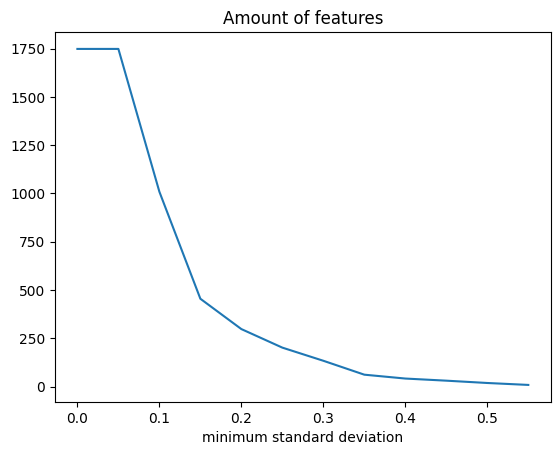

In [23]:
plt.plot([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], X_size)
_ = plt.title("Amount of features")
_ = plt.xlabel("minimum standard deviation")

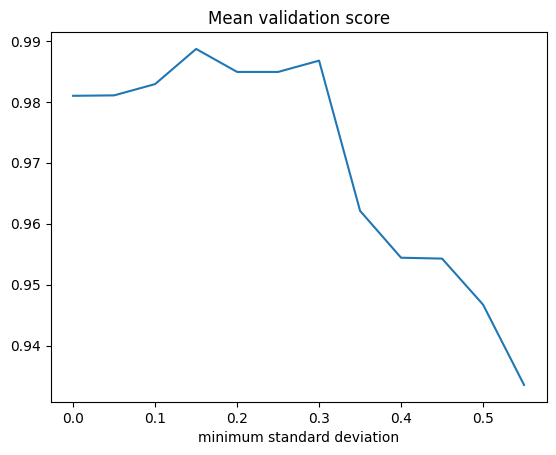

In [24]:
plt.plot([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55], results)
_ = plt.title("Mean validation score")
_ = plt.xlabel("minimum standard deviation")

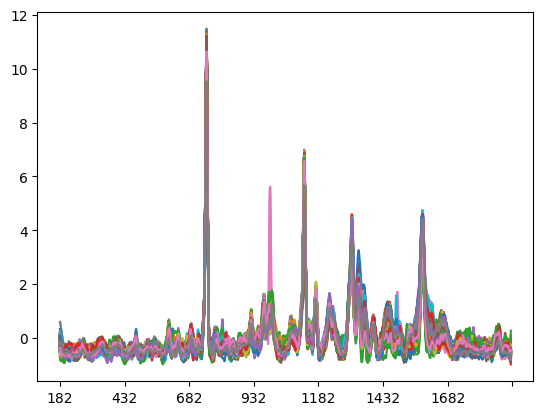

In [31]:
to_drop = X_train.std() > .15
X_train_small = X_train.loc[:, to_drop]
X_test_small = X_test.loc[:, to_drop]
_ = X_train.iloc[:,10:].transpose().plot(legend=False)

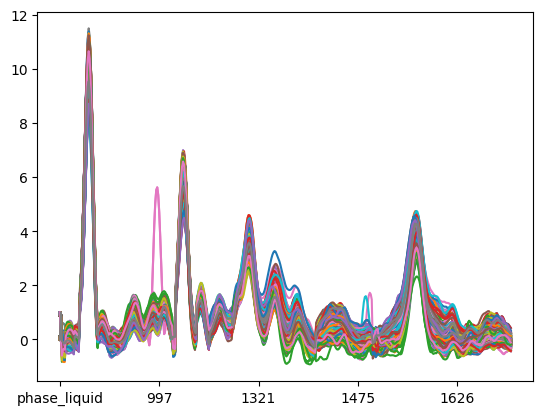

In [32]:
_ = X_train_small.transpose().plot(legend=False)

In [33]:
scaler = StandardScaler()
scaler.fit(X_train_small)
X_train_small = scaler.transform(X_train_small)
X_test_small = scaler.transform(X_test_small)
evaluate_classifier_params(RandomForestClassifier, best_params, X_train_small, truth_train, X_test_small, truth_test, iters=20)

(1.0, 0.9838983050847455)